In [8]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
import math
from matplotlib import pyplot as plt
import urllib
from PIL import Image
from tqdm import tqdm
import seaborn as sns

In [9]:
rating_df = pd.read_csv('../data/cleaned/cleaned_user_rating.csv')
rating_df_copy = rating_df.copy()
movies_df = pd.read_csv('../data/cleaned/cleaned_movies_details.csv', usecols=['movie_id', 'title', 'img_url'])

# ID to number
rating_df_copy['user_id_number'] = rating_df_copy['user_id'].astype('category').cat.codes.values
rating_df_copy['movie_id_number'] = rating_df_copy['movie_id'].astype('category').cat.codes.values

train_data = rating_df_copy[['user_id_number', 'movie_id_number', 'rating']].values
print(train_data)

[[ 35310  17908      8]
 [142632  17908      8]
 [ 47533  17908      1]
 ...
 [153329   6675      8]
 [ 40272   6675      7]
 [ 27285   6675      9]]


# Rating data analysis

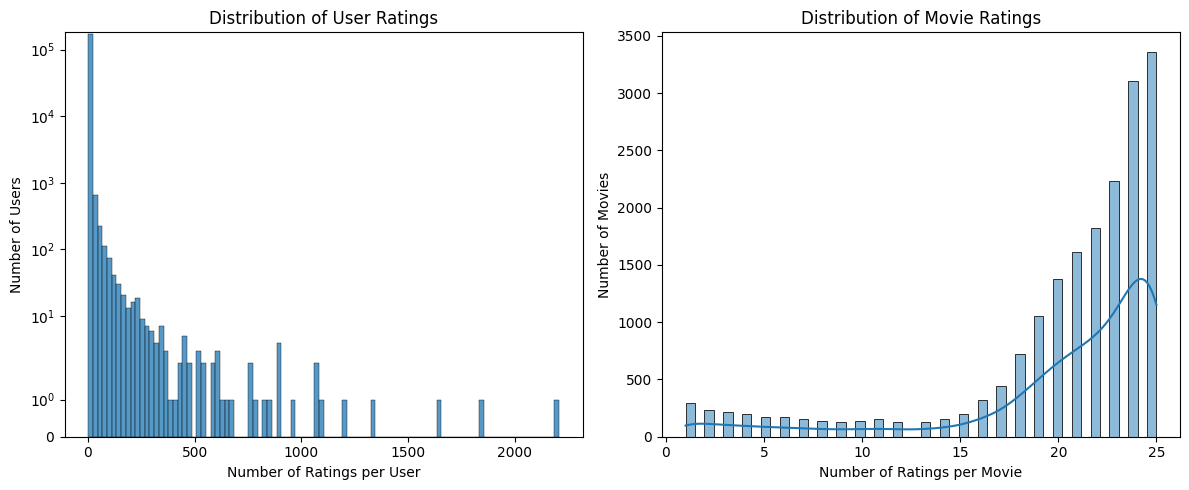

In [10]:
#Count ratings per user and movie using value_counts()
user_counts = rating_df_copy['user_id_number'].value_counts()
movie_counts = rating_df_copy['movie_id_number'].value_counts()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(user_counts, bins=100) # kde=True adds a kernel density estimate
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.yscale('symlog')
plt.title('Distribution of User Ratings')

plt.subplot(1, 2, 2)
sns.histplot(movie_counts, bins=50, kde=True) # kde=True adds a kernel density estimate
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')
plt.title('Distribution of Movie Ratings')

plt.tight_layout()

In [11]:
# Build the mappings
number_to_user_id = dict(enumerate(rating_df_copy['user_id'].astype('category').cat.categories))
user_id_to_number = {v: k for k, v in number_to_user_id.items()}
number_to_movie_id = dict(enumerate(rating_df_copy['movie_id'].astype('category').cat.categories))
movie_id_to_number = {v: k for k, v in number_to_movie_id.items()}
# Example: Get user_id_number for a specific user_id
user_id = 'ur0547823'  
user_id_number = user_id_to_number[user_id]
print(user_id_number)
print(movie_id_to_number['tt11127680'])
# Example: Get user_id for a specific user_id_number
user_id_number = 367  
user_id = number_to_user_id[user_id_number]
print(user_id)

10202
10093
ur0027670


In [12]:
# We may store an array for user_id <=> user_id_number and other types
def get_movieURL(movie_id):
    return movies_df[movies_df.movie_id == movie_id].img_url.values[0]

In [13]:
def split_ratings_by_user(train_data, random_state=420):
    """
    Split ratings for each user into train, validation, and test sets
    with 60:20:20 split and maintaining rating count distribution
    """
    np.random.seed(random_state)
    
    # Unique users
    users = np.unique(train_data[:, 0])
    
    # Initialize empty lists for split data
    train_data_list = []
    val_data_list = []
    test_data_list = []
    
    for user in users:
        user_ratings = train_data[train_data[:, 0] == user]
        total_ratings = len(user_ratings)
        train_end = math.ceil(total_ratings * 0.6)
        val_end = train_end + math.ceil(total_ratings * 0.2)
        
        # Split the data
        train_data_list.append(user_ratings[:train_end])
        val_data_list.append(user_ratings[train_end:val_end])
        test_data_list.append(user_ratings[val_end:])
    
    # Concatenate the lists
    train_data = np.vstack(train_data_list)
    val_data = np.vstack(val_data_list)
    test_data = np.vstack(test_data_list)
    
    return train_data, val_data, test_data

In [14]:
# train_data, val_data, test_data = split_ratings_by_user(train_data)
# np.savez_compressed('../cleaned_data/data.npz', train=train_data, val=val_data, test=test_data)

In [15]:
data = np.load('../checkpoints/data.npz')
train_data = data['train']
val_data = data['val']
test_data = data['test']

In [16]:
def evaluate_recommendation(cf_model, test_data, n_top=5):
    hit_ratios, ndcg_scores = [], []
    
    unique_users = np.unique(test_data[:, 0])
    for u in tqdm(unique_users, desc="Evaluating Users"):
        # Get movies with ratings 8-10 in test data
        user_test_ratings = test_data[test_data[:, 0] == u]
        high_rated_test_movies = user_test_ratings[user_test_ratings[:, 2] >= 8, 1]
        
        if len(high_rated_test_movies) != 0:
            # Get all unrated movies
            train_movies = cf_model.train_data[cf_model.train_data[:, 0] == u, 1]
            all_movies = np.arange(cf_model.n_movies)
            unrated_movies = all_movies[~np.isin(all_movies, np.concatenate([train_movies, user_test_ratings[:, 1]]))]
            
            # Combine the high-rated movie with 99 other unrated movies
            sampled_unrated_movies = np.random.choice(unrated_movies, 99, replace=False)
            
            hit_ratio = 0
            dcg = 0
            # For each high-rated test movie
            for high_rated_movie in high_rated_test_movies:
                
                candidate_movies = np.concatenate([[high_rated_movie], sampled_unrated_movies])
                movie_scores = {i: cf_model.pred(u, i) for i in candidate_movies}
                
                # Sort movies by predicted score
                sorted_movies = sorted(movie_scores, key=movie_scores.get, reverse=True)[:n_top]
                
                # Calculate the benchmark
                if high_rated_movie in sorted_movies:
                    hit_ratio += 1 
                    rank = sorted_movies.index(high_rated_movie) + 1
                    dcg += 1 / math.log2(rank + 1)  # Discount for rank
            hit_ratios.append(hit_ratio / len(high_rated_test_movies))
            ndcg_scores.append(dcg / len(high_rated_test_movies))
            
    return np.mean(hit_ratios), np.mean(ndcg_scores)

In [17]:
class CF(object):
    global user_id_to_number, number_to_user_id, movie_id_to_number, number_to_movie_id
    def __init__(self, train_data, n_neighbor, dist_func = cosine_similarity, type = 1):
        self.type = type # user-user (1) or item-item (0) CF
        self.train_data = train_data
        self.n_neighbor = n_neighbor # number of neighbor points
        self.dist_func = dist_func
        # number of users and items. Remember to add 1 since id starts from 0.
        # Note: in case of user-user and item-item CF, n_users and n_movies 
        # change their role.
        self.n_users = int(np.max(self.train_data[:, 0])) + 1
        self.n_movies = int(np.max(self.train_data[:, 1])) + 1

    def fit(self):
        if self.type == 1:
            self._fit_user_user()
        else:
            self._fit_item_item()
            
    # Learn after getting new ratings
    def _fit_user_user(self):
        users = self.train_data[:, 0] # all user IDs
        self.Ybar_data = self.train_data.copy()
        
        # normalize ratings of each user
        # Add 100 to size of mu to add more after
        self.mu = np.zeros((self.n_users + 100,))
        for u in range(self.n_users):
            # indices need to be integers, so we convert
            ids = np.where(users == u)[0].astype(np.int32)
            ratings = self.train_data[ids, 2]
            self.mu[u] = np.mean(ratings) if len(ratings) > 0 else 0
            self.Ybar_data[ids, 2] = ratings - self.mu[u]
        
        # Sparse matrix representation for efficiency
        self.Ybar = coo_matrix(
            (self.Ybar_data[:, 2], (self.Ybar_data[:, 0], self.Ybar_data[:, 1])),
            shape=(self.n_users + 100, self.n_movies + 100),
            dtype=float
        ).tocsr()
        
    def _fit_item_item(self):
        items = self.train_data[:, 1]  # all item IDs
        self.Ybar_data = self.train_data.copy()

        # Normalize ratings of each item
        # Add 100 to size of mu to add more after
        self.mu = np.zeros((self.n_movies + 100,))
        for i in range(self.n_movies):
            # indices need to be integers, so we convert
            ids = np.where(items == i)[0].astype(np.int32)
            ratings = self.train_data[ids, 2]
            self.mu[i] = np.mean(ratings) if len(ratings) > 0 else 0
            self.Ybar_data[ids, 2] = ratings - self.mu[i]

        # Sparse matrix representation for efficiency
        self.Ybar = coo_matrix(
            (self.Ybar_data[:, 2], (self.Ybar_data[:, 0], self.Ybar_data[:, 1])),
            shape=(self.n_users + 100, self.n_movies + 100),
            dtype=float
        ).tocsc()
        
    def print_recommendation(self, user_id_number, number=10):
        recommended_items = self.recommend(user_id_number)
        recommended_items = recommended_items[:number]

        if self.type:
            print(f'Recommended movie(s) for user {number_to_user_id[user_id_number]} : {recommended_items}')
            
            cols = 5 if number > 5 else number
            rows = math.ceil(number/cols)

            fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
            urls = []

            for i in recommended_items:
                movie_id = rating_df_copy[rating_df_copy.movie_id_number == i].movie_id.values[0]
                urls.append(get_movieURL(movie_id))
                
            for i, ax in enumerate(axes.flat):
                if i < number:
                    ax.imshow(np.array(Image.open(urllib.request.urlopen(urls[i]))))
                    fig.tight_layout()
                    ax.axis('off')
                else:
                    ax.axis('off')
        else:
            movie_id = rating_df_copy[rating_df_copy.movie_id_number == user_id_number].movie_id.values[0]
            url = get_movieURL(movie_id)
            print('Recommend movie', movie_id, 'to user(s) : ', recommended_items)
            plt.imshow(np.array(Image.open(urllib.request.urlopen(url))))
            plt.axis('off')
            
    def recommend(self, u):        
        """
        Determine all unrated items should be recommended for user u (type = 1)
        or all users who might have interest on item u (type = 0).
        """
        ids = np.where(self.train_data[:, 0] == u)[0]
        items_rated_by_u = self.train_data[ids, 1].tolist()
        recommended_items = {}
        for i in range(self.n_movies):
            if i not in items_rated_by_u:
                recommended_items[i] = self.pred(u, i)

        return sorted(recommended_items, key=recommended_items.get, reverse=True)
    
    def pred(self, u, i):
        if self.type == 1:
            ids = np.where(self.train_data[:, 1] == i)[0].astype(np.int32)
            users_rated_i = self.train_data[ids, 0].astype(np.int32)
            
            if len(users_rated_i) == 0:
                return self.mu[u]   
            
            sim = self.dist_func(self.Ybar[u], self.Ybar[users_rated_i]).flatten()
            if len(sim) < self.n_neighbor:
                return self.mu[u]
            
            a = np.argsort(sim)[-self.n_neighbor:]
            nearest_sim = sim[a]
            r = self.Ybar[users_rated_i[a], i]
            
            return (r.T @ nearest_sim) / (np.abs(nearest_sim).sum() + 1e-12) + self.mu[u]
        else:
            ids = np.where(self.train_data[:, 0] == u)[0].astype(np.int32)
            items_rated_by_u = self.train_data[ids, 1].astype(np.int32)
            
            if len(items_rated_by_u) == 0:
                return self.mu[i]
            
            sim = self.dist_func(self.Ybar[:, i].T, self.Ybar[:, items_rated_by_u].T).flatten()
            if len(sim) < self.n_neighbor:
                return self.mu[i]
                        
            a = np.argsort(sim)[-self.n_neighbor:]
            nearest_sim = sim[a]
            r = self.Ybar[u, items_rated_by_u[a]]
            
            return (r @ nearest_sim) / (np.abs(nearest_sim).sum() + 1e-12) + self.mu[i]
        
    # Incrementally update the model when a new rating is added    
    def incremental_update(self, new_ratings):
        # Convert new_ratings from IDs to numerical indices
        processed_ratings = []
        for user_id, movie_id, rating in new_ratings:
            # Check and update user_id_to_number
            if user_id not in user_id_to_number:
                user_id_to_number[user_id] = self.n_users
                number_to_user_id[self.n_users] = user_id
                self.n_users += 1

            # Check and update movie_id_to_number
            if movie_id not in movie_id_to_number:
                movie_id_to_number[movie_id] = self.n_movies
                number_to_movie_id[self.n_movies] = movie_id
                self.n_movies += 1

            # Convert IDs to numbers and append to processed_ratings
            u = user_id_to_number[user_id]
            i = movie_id_to_number[movie_id]
            processed_ratings.append([u, i, rating])        
        
        # Convert processed_ratings to a NumPy array
        processed_ratings = np.array(processed_ratings)
        # Update the train_data matrix with the new ratings
        self.train_data = np.vstack((self.train_data, processed_ratings))
        
        # User-User CF
        if self.type == 1:
            for u, i, r in processed_ratings:
                u, i, r = int(u), int(i), int(r)
                # Update user mean
                user_ratings = self.train_data[self.train_data[:, 0] == u, 2]
                if len(user_ratings) == 0:
                    self.mu[u] = r
                else:
                    new_mean = (self.mu[u] * (len(user_ratings)-1) + r) / (len(user_ratings))
                    delta = new_mean - self.mu[u]
                    self.mu[u] = new_mean
            
                    # Update normalized ratings (Ybar)
                    rated_items = self.train_data[self.train_data[:, 0] == u, 1].astype(int)
                    for j in rated_items:
                        self.Ybar[u, j] -= delta

                # Update Ybar matrix
                self.Ybar[u, i] = r - self.mu[u]
        
        # Item-Item CF
        else:
            for u, i, r in processed_ratings:
                u, i, r = int(u), int(i), int(r)
                # Update item mean
                item_ratings = self.train_data[self.train_data[:, 1] == i, 2]
                if len(item_ratings) == 0:
                    self.mu[i] = r
                else:
                    new_mean = (self.mu[i] * (len(item_ratings)-1) + r) / (len(item_ratings))
                    delta = new_mean - self.mu[i]
                    self.mu[i] = new_mean
                    
                    # Update normalized ratings (Ybar)
                    rated_users = self.train_data[self.train_data[:, 1] == i, 0].astype(int)
                    for v in rated_users:
                        self.Ybar[v, i] -= delta

                # Update Ybar matrix
                self.Ybar[u, i] = r - self.mu[i]

In [20]:
cf_model = CF(train_data=train_data, n_neighbor = 5, type=1)
cf_model.fit()

# Evaluate
hit_ratio, ndcg = evaluate_recommendation(cf_model, val_data, n_top = 5)
print(f"User-User CF - Validation - Hit Ratio: {hit_ratio:.4f}, NDCG: {ndcg:.4f}")

hit_ratio, ndcg = evaluate_recommendation(cf_model, test_data, n_top = 5)
print(f"User-User CF - Test - Hit Ratio: {hit_ratio:.4f}, NDCG: {ndcg:.4f}")

cf_model = CF(train_data=train_data, n_neighbor=5, type=0)
cf_model.fit()

# Evaluate on validation data
hit_ratio, ndcg = evaluate_recommendation(cf_model, val_data, n_top = 5)
print(f"Item-Item CF - Validation - Hit Ratio: {hit_ratio:.4f}, NDCG: {ndcg:.4f}")

hit_ratio, ndcg = evaluate_recommendation(cf_model, test_data, n_top = 5)
print(f"Item-Item CF - Test - Hit Ratio: {hit_ratio:.4f}, NDCG: {ndcg:.4f}")

Evaluating Users: 100%|██████████| 16317/16317 [1:37:46<00:00,  2.78it/s]
User-User CF - Validation - Hit Ratio: 0.8151, NDCG: 0.6423
Evaluating Users: 100%|██████████| 6084/6084 [1:24:55<00:00,  1.19it/s]
User-User CF - Test - Hit Ratio: 0.6683, NDCG: 0.4809
Evaluating Users: 100%|██████████| 16317/16317 [2:14:05<00:00,  2.03it/s]
Item-Item CF - Validation - Hit Ratio: 0.0495, NDCG: 0.0269
Evaluating Users: 100%|██████████| 6084/6084 [1:54:57<00:00,  1.13s/it]
Item-Item CF - Test - Hit Ratio: 0.0539, NDCG: 0.0290


## User-based Collaborative Filtering

10202
Recommended movie(s) for user ur0547823 : [11717, 3464, 18270, 17118, 2350, 16416, 3555, 9370, 17324, 5303]


e:\miniconda3\envs\GECCO2025\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


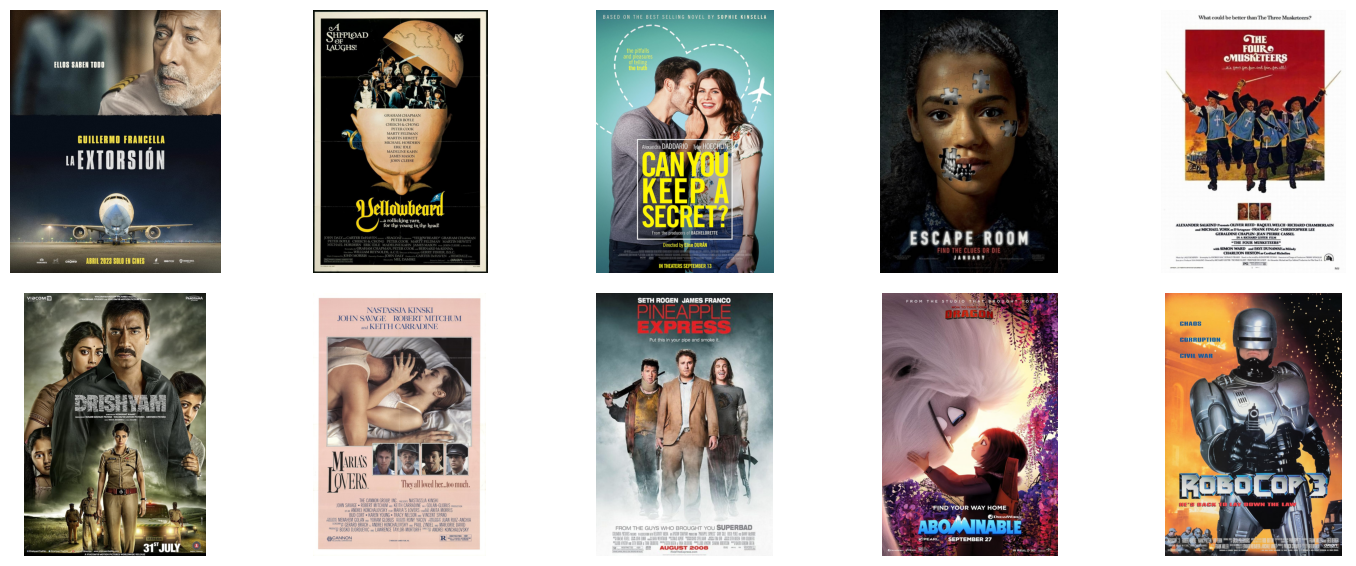

In [22]:
user_based_cf = CF(train_data, n_neighbor = 5, type = 1)
user_based_cf.fit()
user_id = 'ur0547823'
# convert user_id to user_id_number
user_id_number = user_id_to_number[user_id]
print(user_id_number)
user_based_cf.print_recommendation(user_id_number)
new_ratings = np.array([['ur0547823', 'tt7322224', 3], ['ur6969', 'tt6969', 7]])  # Example new ratings
user_based_cf.incremental_update(new_ratings)

Recommend movie tt30327762 to user(s) :  [229, 503, 1336, 1767, 1891, 2026, 2451, 2781, 3023, 3163]


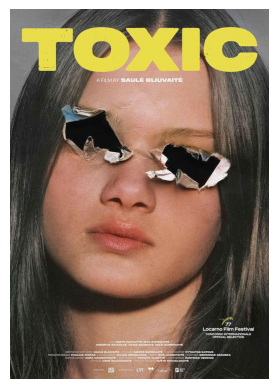

In [24]:
item_based_cf = CF(train_data, n_neighbor = 5, type = 0)
item_based_cf.fit()
movie_id = 'tt30327762'
movie_id_number = movie_id_to_number[movie_id]
item_based_cf.print_recommendation(movie_id_number)